In [117]:
# !pip install -r ../requirements.txt

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Calculate the Point score

In [119]:
def get_points(bounds, value, fruit_flag=False):
    if fruit_flag:
        if value > 80:
            return 5
    for i in range(len(bounds) - 1):
        if bounds[i] < value <= bounds[i + 1]:
            return i
    return len(bounds) - 1 if value > bounds[-1] else 0

In [120]:
def CalculatePoints(product):
    '''
    Define the bounds for each of the four categories for negative nutrients and positive nutrients
    '''
    # negative nutrients: energy, sugar, sodium, saturated fatty acid
    energy_bounds = [0, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350]
    sugars_bounds = [0, 4.5, 9, 13.5, 18, 22.5, 27, 31.5, 36, 40.5, 45]
    sodium_bounds = [0, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900]
    saturated_fatty_acid_bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    # positive nutrients: fruit, fiber, protein
    fruit_bounds = [0, 40, 60, 80, 100]
    fiber_bounds = [0, 0.9, 1.9, 2.8, 3.7, 4.7]
    proteins_bounds = [0, 1.6, 3.2, 4.8, 6.4, 8.0]

    # Find the points for each of the four categories for negative nutrients
    energy_points = get_points(energy_bounds, product['energy-kj_100g'])
    sugars_points = get_points(sugars_bounds, product['sugars_100g'])
    sodium_points = get_points(sodium_bounds, product['sodium_100g'])
    saturated_fatty_acid_points = get_points(saturated_fatty_acid_bounds, product['saturated-fat_100g'])

    # find the points for the positive nutrients
    fruit_points = get_points(fruit_bounds, product['fruits-vegetables-nuts-estimate-from-ingredients_100g'], fruit_flag=True)
    fiber_points = get_points(fiber_bounds, product['fiber_100g'])
    protein_points = get_points(proteins_bounds, product['proteins_100g'])

    # append the points to the dataframe
    product['energy_points'] = energy_points
    product['sugars_points'] = sugars_points
    product['sodium_points'] = sodium_points
    product['saturated_fat_points'] = saturated_fatty_acid_points
    product['fruit_points'] = fruit_points
    product['fiber_points'] = fiber_points
    product['proteins_points'] = protein_points

    return product

In [121]:
# Obtaining the points
t1 = pd.read_csv('../data/final_preprocessed_data.csv')
t2 = t1.apply(CalculatePoints, axis = 1)

t2 = t2.drop_duplicates()
t2 = t2.dropna(how = 'any')
t2.to_csv('../data/final_preprocessed_data_points.csv', index = False)

### Defining criteria

In [122]:
en = "energy_points"
su = "sugars_points"
fa = "saturated_fat_points"
sa = "sodium_points"
pr = "proteins_points"
fi = "fiber_points"
fr = "fruit_points"

criteria_to_minimize = {en, su, fa, sa}
criteria_to_maximize = {pr, fi, fr}

### Defining Additive Models

In [123]:
# Additive model 
def new_scale_transform(df):
    """
    Defines a new transformed scale for each criterion:
    1. x'_i = 10 - x_i for the criteria to be minimized i ∈ {en, su, fa, sa}
    2. x'_i = 2 * x_i for the criteria to be maximized i ∈ {pr, fi, fr}
    """
    for column in df.columns:
        if column in criteria_to_minimize:
            df[column] = 10 - df[column]
        elif column in criteria_to_maximize:
            df[column] = 2 * df[column]
    return df

In [124]:
def our_model(df):
    # 40 − F(x) = 40 - F(x'_en, x'_su, x'_fa, x'_sa, x'_pr, x'_fi, x'_fr) = 40 - x'_en + x'_su + x'_fa + x'_sa + 1/2(x'_pr + x'_fi) + x'fr
    return 15.75 - (0.5*df[en] + 0.1*df[su] + 0.4*df[fa] + 0.35*df[sa] + 0.2*df[pr] + 0.3*df[fi] - 0.05*df[fr])

### Defining Labels for Additive Models

In [125]:
def normal_model_labels(df):
    score = df['our_nutrition_score']
    return np.where(score < 0, 'a',
                    np.where(score <= 2 , 'b',
                                np.where(score < 11/ 3.075 +1 , 'c',
                                        np.where(score < 19/ 3.075, 'd',
                                                np.where(score <= 15.75, 'e', 'ERROR')))))

### Working on data

In [126]:
df = pd.read_csv('../data/final_preprocessed_data_points.csv')

In [127]:
df = new_scale_transform(df)
df.head(2)

,_id,image_url,brands,pnns_groups_2,energy-kj_100g,sugars_100g,salt_100g,saturated-fat_100g,proteins_100g,fiber_100g,...,nutrition_grade_fr,negative_points,positive_points,energy_points,sugars_points,sodium_points,saturated_fat_points,fruit_points,fiber_points,proteins_points
0,3.251492e+12,https://images.openfoodfacts.org/images/produc...,Gerblé,Biscuits and cakes,1817.0,21.0,0.00,1.3,9.4,6.4,...,b,10.0,10.0,5,6,10,9,0,10,10
1,3.175680e+12,https://images.openfoodfacts.org/images/produc...,Gerblé,Biscuits and cakes,1961.0,17.0,0.38,2.0,10.0,4.6,...,b,10.0,9.0,5,7,10,9,0,8,10


In [128]:
# calculate score using normal model
df['our_nutrition_score'] = our_model(df)

In [129]:
# assign label for normal model
df['our_nutrition_label'] = normal_model_labels(df)
df.to_csv('../data/final_preprocessed_data_points_grades.csv', index = False)

In [130]:
df.head(2)

,_id,image_url,brands,pnns_groups_2,energy-kj_100g,sugars_100g,salt_100g,saturated-fat_100g,proteins_100g,fiber_100g,...,positive_points,energy_points,sugars_points,sodium_points,saturated_fat_points,fruit_points,fiber_points,proteins_points,our_nutrition_score,our_nutrition_label
0,3.251492e+12,https://images.openfoodfacts.org/images/produc...,Gerblé,Biscuits and cakes,1817.0,21.0,0.00,1.3,9.4,6.4,...,10.0,5,6,10,9,0,10,10,0.55,b
1,3.175680e+12,https://images.openfoodfacts.org/images/produc...,Gerblé,Biscuits and cakes,1961.0,17.0,0.38,2.0,10.0,4.6,...,9.0,5,7,10,9,0,8,10,1.05,b


In [131]:
df['nutrition_grade_fr'].value_counts()

nutrition_grade_fr
a    115
b     54
c     31
d     14
e      5
Name: count, dtype: int64

In [132]:
df['our_nutrition_label'].value_counts()

our_nutrition_label
a    99
b    77
c    33
d     7
e     3
Name: count, dtype: int64

In [133]:
df['our_nutrition_score'].value_counts()

our_nutrition_score
-0.55    19
-0.75    16
 0.45     9
 0.55     6
-0.65     6
         ..
 5.15     1
 4.75     1
 6.25     1
 6.45     1
 0.85     1
Name: count, Length: 74, dtype: int64

### Checking and comparing different additive models

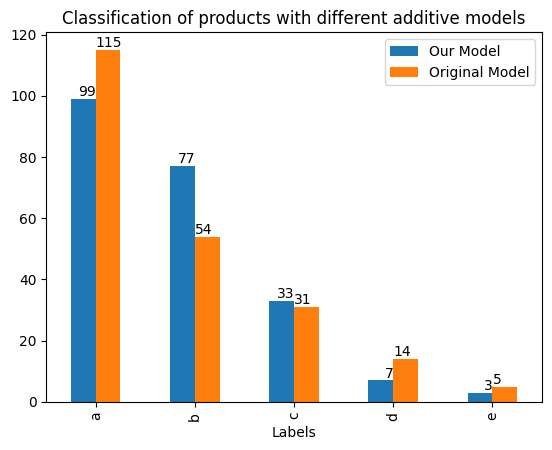

In [134]:
compare = pd.DataFrame(df['our_nutrition_label'].value_counts())
compare['our_nutrition_label'] = pd.DataFrame(df['our_nutrition_label'].value_counts())
compare['original_label'] = df['nutrition_grade_fr'].value_counts()
compare['Labels'] = compare.index
compare.sort_index(inplace = True)

fig, ax = plt.subplots()
compare.plot(x = 'Labels', y = ['our_nutrition_label', 'original_label'], kind="bar", ax=ax, title="Classification of products with different additive models")
ax.legend(["Our Model","Original Model"])

for i, val in enumerate(compare['our_nutrition_label']):
    ax.text(i, val, str(val), ha='right', va='bottom')

for i, val in enumerate(compare['original_label']):
    ax.text(i, val, str(val), ha='left', va='bottom')

plt.show()

Confusion Matrix:
Predicted   a   b   c  d  e
Actual                     
a          79  25  11  0  0
b          14  37   3  0  0
c           6  15   9  1  0
d           0   0  10  3  1
e           0   0   0  3  2


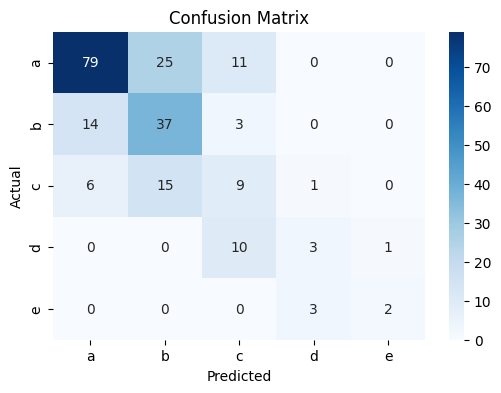

In [135]:
# Create a confusion matrix using crosstab
confusion_matrix = pd.crosstab(df['nutrition_grade_fr'], df['our_nutrition_label'], rownames=['Actual'], colnames=['Predicted'])

print("Confusion Matrix:")
print(confusion_matrix)
# Plotting the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()